# Unsupervised federated learning: K-means clustering

The present notebook tackles the problem of *unsupervised* learning in a federated configuration. 
In particular, a K-Means clustering is used from the `sklearn` library (see [this link](https://scikit-learn.org/stable/modules/clustering.html#k-means)).

## Model definition
In order to make the model interact with the Federated Learning platform we will simply need to define the following:
1. How to load the data;
2. The model.
3. How to aggregate model's parameters from each federated node. 

In the following, each step is described for the case of a 2D clustering. 

**How to load the data**\
A method that returns train, test and validation data need to be provided, wrapping it in the class `data_base`.\
Typically, existing data is used. 
However, in this example a series of 2D points is created for simplicity:

Using TensorFlow backend.


(201, 2)
(21, 2)
(300, 2)


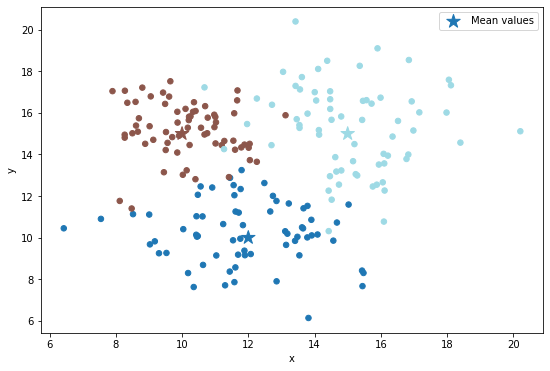

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import shfl
from shfl.data_base import data_base as db

# Create database: 
class ClusteringDB(db.DataBase):
    """
    Create clusters of 2D points
    """
    
    def __init__(self):
        """
        Change these parameters to modify dataset
        """
        # True centers of clusters:
        self._mean = np.array([[12, 10],
                               [10, 15],
                               [15, 15]])
        # Covariance for each cluster: [s_xx, s_xy, s_yx, s_yy]
        self._cov = np.array([[3, 0, 0, 3],
                              [2, 0, 0, 2],
                              [4, 0, 0, 4]])
        # Size of datasets:
        self._size_train = 200
        self._size_test = 300
        self._size_validation = 20
        
    def _create_data(self, size_data):
        data = np.empty((0, 3))
        size_cluster = round(size_data / (self._mean).shape[0])
        for i_cluster in range((self._mean).shape[0]):
            i_data = np.random.multivariate_normal( \
                        self._mean[i_cluster,:], self._cov[i_cluster,:].reshape(2,2), size_cluster)
            # Add column for label:
            i_data = np.concatenate([i_data, \
                        np.ones((i_data.shape[0],1), dtype=i_data.dtype) * i_cluster], axis=1)
            # Append cluster data:
            data = np.append(data, i_data, axis = 0)
        return(data[:, [0, 1]], data[:, 2]) 
       
    def load_data(self):
        self._train_data, self._train_labels = self._create_data(self._size_train)
        self._test_data, self._test_labels = self._create_data(self._size_test)
        self._validation_data, self._validation_labels = self._create_data(self._size_validation)
        self.shuffle()
        return self.data

# Assign database:    
database = ClusteringDB()

train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

# Visualize train data: 
fig, ax = plt.subplots(figsize=(9,6))
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=30, cmap="tab20")
plt.scatter(database._mean[:, 0], database._mean[:, 1], c=[0,1,2], marker='*', s=200, cmap="tab20", label = "Mean values")
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.legend(title = "")
plt.show()

**Define the model** <br/>
Now we will define the model and wrap it in the class `TrainableModel`. 
Abstract methods need to be defined, i.e. we must provide functions for `train`, `predict`, `evaluate`, `get_parameters` and `set_parameters`. 
In the case of 2D clustering, a possible implementation is the following:

In [2]:
from sklearn import metrics
from sklearn.cluster import KMeans
from shfl.model import TrainableModel

class K_Means2D(TrainableModel):
    
    def __init__(self, n_clusters, init, n_init=1):
        self._k_means = KMeans(n_clusters=n_clusters, init=init, n_init=n_init)
        self._k_means.cluster_centers_ = init
        
    def train(self, data, labels = None):
        self._k_means.fit(data)
        
    def predict(self, data):
        predicted_labels = self._k_means.predict(data)
        return(predicted_labels)
    
    def evaluate(self, data, labels):
        """
        Add here all the metrics to evaluate the performance 
        """
        prediction = self.predict(data)
    
        homo = metrics.homogeneity_score(labels, prediction) 
        compl = metrics.completeness_score(labels, prediction)
        v_meas = metrics.v_measure_score(labels, prediction)
        rai = metrics.adjusted_rand_score(labels, prediction)
        return homo, compl, v_meas, rai

    def get_model_params(self):
        return self._k_means.cluster_centers_
    
    def set_model_params(self, params):
        """
        New model with initial centers
        """
        n_clusters = params.shape[0]
        self.__init__(n_clusters=n_clusters, init=params)
        
        

We can check that the implementation is correct:

[[12.06043536 10.18843281]
 [10.31395362 15.17294105]
 [15.36323092 15.51899208]]


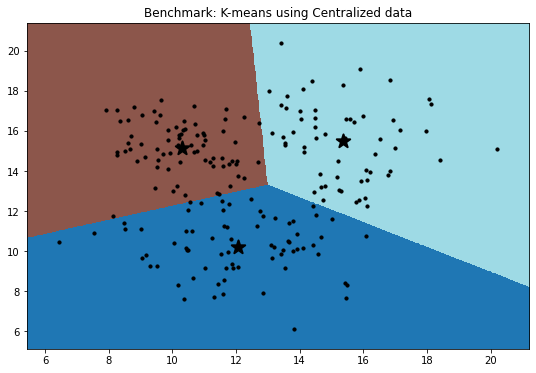

In [3]:
def plot_k_means(KMeans_model, data, title):
    # Step size of the mesh. Smaller it is, better the quality
    h = .02 
    
    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = KMeans_model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(9,6))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.tab20,
               aspect='auto', origin='lower')
    # Plot data:
    plt.scatter(data[:, 0], data[:, 1], s=40, color = 'k', marker='.')
    
    # Plot the centroids
    centroids = KMeans_model.get_model_params()
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='*', s=200, linewidths=2,
                color='black', zorder=10)
    plt.title(title)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    
# Plot train data:
model_centralized = K_Means2D(n_clusters=3, init = database._mean)
model_centralized.train(train_data)
print(model_centralized.get_model_params())
plot_k_means(model_centralized, train_data, title = "Benchmark: K-means using Centralized data")

**How to aggregate model's parameters from each federated node** <br/>
Next, we define the aggregation of the federated outputs to be the average. 
Since the labels of clusters can vary among each node, we cannot average the centroids right away. 
A solution is to choose the lowest distance average: this is achieved by simply applying the k-means algorithm on the centroids coordinates of all nodes. 
The class `ClusterAvgFedAggregator` below shows the implementation. 

In [4]:
from shfl.federated_aggregator.federated_aggregator import FederatedAggregator

class ClusterAvgFedAggregator(FederatedAggregator):
    """
    Implementation of Cluster Average Federated Aggregator. 
    It adds another k-means to find the minimum distance of cluster centroids coming from each node. 
    """

    def aggregate_weights(self, clients_params):
        clients_params_array = np.concatenate((clients_params))
        
        n_clusters = clients_params[0].shape[0]
        model_aggregator = KMeans(n_clusters=n_clusters, init='k-means++')
        model_aggregator.fit(clients_params_array)
        aggregated_weights = np.array(model_aggregator.cluster_centers_)
        return aggregated_weights

## Running the model in a Federated configuration
We are now ready to run our model in a federated configuration. 
We distribute the data over the nodes, assuming the data is IID.\
The performance is assessed by several clustering metrics (see [this link](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)).\
For reference, below we compare the metrics of:
 - Each node; 
 - The global (federated) model;
 - The centralized (non-federated) model.
 
It can be observed that the performance of *Global federated model* is in general superior with respect to the performance of each node, thus the federated learning approach proves to be beneficial. Moreover, the performance of the Global federated model is very close to the performance of the centralized model.

Number of nodes: 12
Test data size: 300


Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6630>: (0.5356855426552444, 0.564303284988597, 0.5496221485971855, 0.5473423143833474)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6dd8>: (0.30134528311748743, 0.339810426249068, 0.31942402635849, 0.29635543124453484)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc461ec588>: (0.3237633514335041, 0.44749087745592875, 0.3757026951532506, 0.36135578033020754)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc46247d68>: (0.5371310056602602, 0.5619582834492362, 0.5492642334323222, 0.559849161953252)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc4b3d7c88>: (0.2546954627322041, 0.30236945308280744, 0.27649247182022524, 0.2099989834886825)
Test performance cli

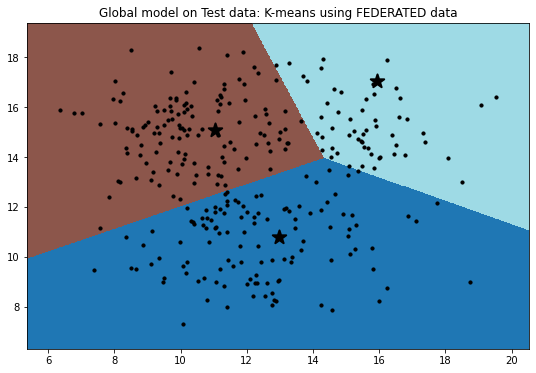




Accuracy round 1
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6630>: (0.5356855426552444, 0.564303284988597, 0.5496221485971855, 0.5473423143833474)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6dd8>: (0.42523275893544077, 0.4429880453998935, 0.43392885261491476, 0.4163447307852338)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc461ec588>: (0.5896114813965303, 0.6057320480158549, 0.5975630626210874, 0.6225463947429724)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc46247d68>: (0.6264125880130439, 0.634613932995286, 0.6304865909383798, 0.6750211366776069)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc4b3d7c88>: (0.432946366110548, 0.47708798703371375, 0.4539466220974606, 0.3967947518231686)
Test performance client <shfl.private.federated_operation.Fe

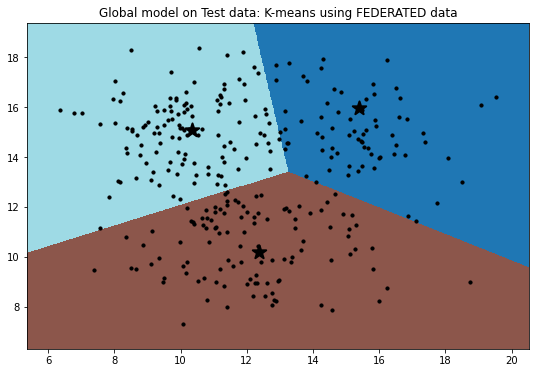




Accuracy round 2
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6630>: (0.6227097897706306, 0.6263648941707444, 0.6245319940966383, 0.6783251601041703)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6dd8>: (0.42523275893544077, 0.4429880453998934, 0.43392885261491476, 0.4163447307852338)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc461ec588>: (0.5896114813965303, 0.6057320480158549, 0.5975630626210874, 0.6225463947429724)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc46247d68>: (0.6334676804054088, 0.6389489367224243, 0.6361965026151383, 0.6916091349029161)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc4b3d7c88>: (0.42156962049700375, 0.4571075164632276, 0.43861990744036494, 0.38426991782276587)
Test performance client <shfl.private.federated_operati

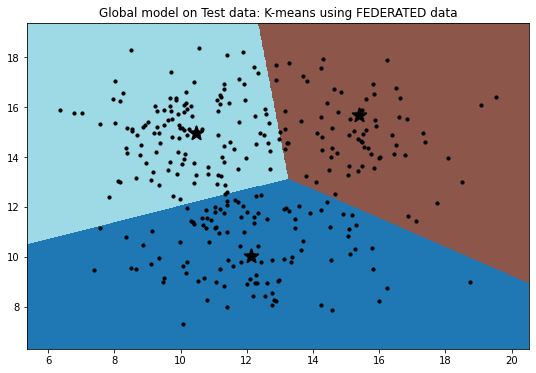




Accuracy round 3
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6630>: (0.6227097897706306, 0.6263648941707444, 0.6245319940966383, 0.6783251601041703)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6dd8>: (0.4252327589354408, 0.44298804539989345, 0.43392885261491476, 0.4163447307852338)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc461ec588>: (0.5896114813965303, 0.6057320480158549, 0.5975630626210874, 0.6225463947429724)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc46247d68>: (0.6334676804054089, 0.6389489367224244, 0.6361965026151384, 0.6916091349029161)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc4b3d7c88>: (0.42156962049700364, 0.4571075164632275, 0.43861990744036483, 0.38426991782276587)
Test performance client <shfl.private.federated_operati

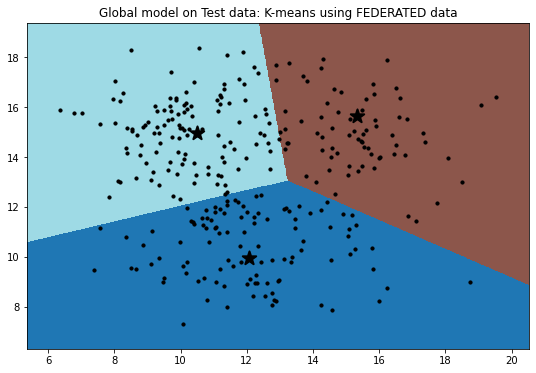




Accuracy round 4
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6630>: (0.6227097897706306, 0.6263648941707444, 0.6245319940966383, 0.6783251601041703)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6dd8>: (0.4252327589354408, 0.44298804539989345, 0.43392885261491476, 0.4163447307852338)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc461ec588>: (0.5896114813965303, 0.6057320480158549, 0.5975630626210874, 0.6225463947429724)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc46247d68>: (0.6334676804054089, 0.6389489367224244, 0.6361965026151384, 0.6916091349029161)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc4b3d7c88>: (0.42156962049700364, 0.4571075164632275, 0.43861990744036483, 0.38426991782276587)
Test performance client <shfl.private.federated_operati

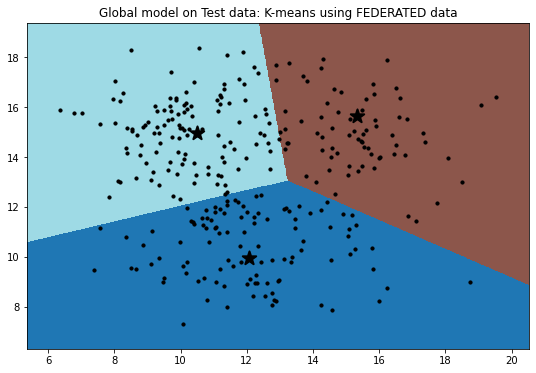




Accuracy round 5
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6630>: (0.6227097897706306, 0.6263648941707444, 0.6245319940966383, 0.6783251601041703)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc460a6dd8>: (0.4252327589354408, 0.44298804539989345, 0.43392885261491476, 0.4163447307852338)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc461ec588>: (0.5896114813965303, 0.6057320480158549, 0.5975630626210874, 0.6225463947429724)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc46247d68>: (0.6334676804054089, 0.6389489367224244, 0.6361965026151384, 0.6916091349029161)
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7efc4b3d7c88>: (0.42156962049700364, 0.4571075164632275, 0.43861990744036483, 0.38426991782276587)
Test performance client <shfl.private.federated_operati

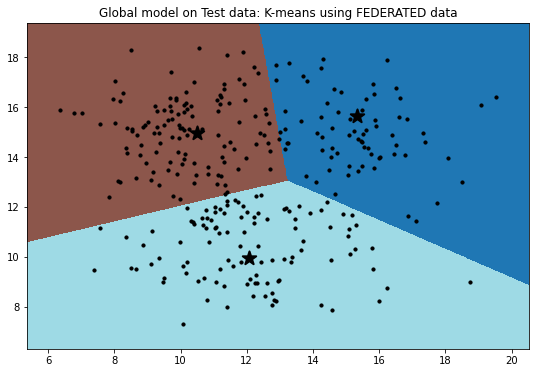




Centralized model test performance : (0.6425040845678647, 0.6543168922001246, 0.6483566866539731, 0.6779798198079225)


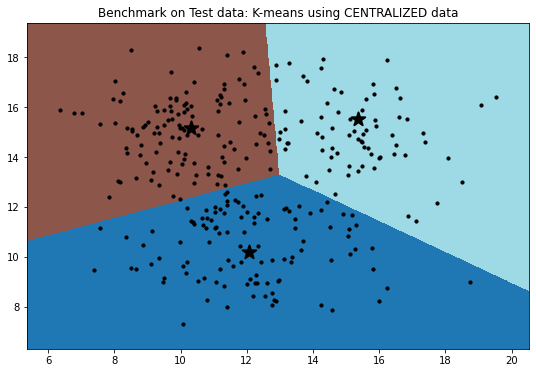

In [16]:
from shfl.learning_approach.federated_government import FederatedGovernment

# Use this to Plot after each Aggregation:
class PlotFederatedGovernment(FederatedGovernment):
    def evaluate_global_model(self, data_test, label_test):
        evaluation = self._model.evaluate(data_test, label_test)
        print("Global model test performance : " + str(evaluation))
        plot_k_means(self._model, data_test, title = "Global model on Test data: K-means using FEDERATED data")

        
n_clusters = 3 # Set number of clusters
def model_builder():
    model = K_Means2D(n_clusters=n_clusters, init=np.zeros((n_clusters, 2)))
    return model

# Create the IID data: 
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_label = iid_distribution.get_federated_data(num_nodes = 12, percent=100)
print("Number of nodes: " + str(federated_data.num_nodes()))

# Run the algorithm:
aggregator = ClusterAvgFedAggregator()
federated_government = PlotFederatedGovernment(model_builder, federated_data, aggregator)
print("Test data size: " + str(test_data.shape[0]))
print("\n")
federated_government.run_rounds(n = 6, test_data = test_data, test_label = test_label)

# Reference Centralized (non federate) model:
print("Centralized model test performance : " + str(model_centralized.evaluate(data=test_data, labels=test_labels)))
plot_k_means(model_centralized, test_data, title = "Benchmark on Test data: K-means using CENTRALIZED data")